In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from scipy.special import erfcinv
from scipy.optimize import curve_fit, minimize
from scipy import stats
from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic

import sys

In [2]:
SR_left = 9.0
SR_right = 10.6
SB_left = 5.0
SB_right = 16.0
num_bins_SR = 12

try:
    FPR_index = int(sys.argv[1])
except:
    print('Please provide an FPR index, Defaulting to 0')
    FP_index = 0

def parametric_fit(x, *theta):

    degree = len(theta) - 1
    y = np.zeros_like(x)
    for i in range(degree + 1):
        y += theta[i] * (x)**i

    return y

def integral(lower, upper, bin_width, *theta):

    degree = len(theta) - 1
    integral = 0
    for i in range(degree + 1):
        integral += theta[i] / (i + 1) * ((upper)**(i + 1) - (lower)**(i + 1))

    return integral / bin_width


plot_bins_SR = np.linspace(SR_left, SR_right, num_bins_SR)
plot_centers_SR = 0.5*(plot_bins_SR[1:] + plot_bins_SR[:-1])
width = plot_bins_SR[1] - plot_bins_SR[0]

plot_bins_left = np.arange(SR_left, SB_left-width,  -width)[::-1]
if plot_bins_left[0] < SB_left:
    plot_bins_left = plot_bins_left[1:]
plot_centers_left = 0.5*(plot_bins_left[1:] + plot_bins_left[:-1])

plot_bins_right = np.arange(SR_right, SB_right+width, width)
if plot_bins_right[-1] > SB_right:
    plot_bins_right = plot_bins_right[:-1]
plot_centers_right = 0.5*(plot_bins_right[1:] + plot_bins_right[:-1])

plot_bins = np.concatenate((plot_bins_left, plot_bins_SR, plot_bins_right))
plot_centers = np.concatenate((plot_centers_left, plot_centers_SR, plot_centers_right))

plot_centers_SB = np.concatenate((plot_centers_left, plot_centers_right))

def likelihood(data, s, *theta):

    # get left SB data
    loc_bkg_left = data[data < SR_left]
    y_vals_left, _ = np.histogram(loc_bkg_left, bins = plot_bins_left, density = False)

    # get right SB data
    loc_bkg_right = data[data > SR_right]
    y_vals_right, _ = np.histogram(loc_bkg_right, bins = plot_bins_right, density = False)

    # Log poisson likelihood for the SB bins
    log_likelihood = 0
    fit_vals_left = parametric_fit(plot_centers_left, *theta)
    fit_vals_right = parametric_fit(plot_centers_right, *theta)
    for i in range(len(y_vals_left)):
        log_likelihood += stats.poisson.logpmf(y_vals_left[i], fit_vals_left[i])
    for j in range(len(y_vals_right)):
        log_likelihood += stats.poisson.logpmf(y_vals_right[j], fit_vals_right[j])

    # get SR data
    bin_width = plot_bins_SR[1] - plot_bins_SR[0]
    loc_data = data[np.logical_and(data > SR_left, data < SR_right)]
    num_SR = len(loc_data)
    num_bkg = integral(SR_left, SR_right, bin_width, *theta)

    # Log poisson likelihood for the SR
    s_prime = s * (s > 0) # Ensure positive signal. If negative, this will cancel out in the likelihood ratio
    log_likelihood += stats.poisson.logpmf(num_SR, num_bkg + s_prime)

    return -2 * log_likelihood
    
def cheat_likelihood(data, *theta):

    # get left SB data
    loc_bkg_left = data[data < SR_left]
    y_vals_left, _ = np.histogram(loc_bkg_left, bins = plot_bins_left, density = False)

    # get right SB data
    loc_bkg_right = data[data > SR_right]
    y_vals_right, _ = np.histogram(loc_bkg_right, bins = plot_bins_right, density = False)

    # Log poisson likelihood for the SB bins
    log_likelihood = 0
    fit_vals_left = parametric_fit(plot_centers_left, *theta)
    fit_vals_right = parametric_fit(plot_centers_right, *theta)
    for i in range(len(y_vals_left)):
        log_likelihood += stats.poisson.logpmf(y_vals_left[i], fit_vals_left[i])
    for j in range(len(y_vals_right)):
        log_likelihood += stats.poisson.logpmf(y_vals_right[j], fit_vals_right[j])

    return -2 * log_likelihood
    
def null_hypothesis(data, *theta):
    return likelihood(data, 0, *theta)

def calculate_test_statistic(data, degree = 5, starting_guess = None, verbose_plot = False, return_popt = False):

    # We want to determine the profiled log likelihood ratio: -2 * [L(s, theta_hat_hat) - L(s_hat, theta_hat)]
    # for s = 0

    # Set up 
    bin_width = plot_bins_SR[1] - plot_bins_SR[0]
    average_bin_count = len(data) / len(plot_bins)
    if starting_guess is None:
        starting_guess = [average_bin_count, 0, 0, 0, 0, 0, 0, 0, 0, 0]




    # Fit the s = 0 hypothesis
    lambda_null = lambda theta: null_hypothesis(data, *theta)
    fit = minimize(lambda_null , x0 = starting_guess, method = 'Nelder-Mead', options = {'maxiter': 15000, "disp": verbose_plot})
    theta_hat_hat = fit.x
    null_fit_likelihood = null_hypothesis(data, *theta_hat_hat)


        # Fit the s = float hypothesis
    lambda_cheat = lambda theta: cheat_likelihood(data, *theta)
    fit = minimize(lambda_cheat , x0 = theta_hat_hat, method = 'Nelder-Mead', options = {'maxiter': 15000, "disp": verbose_plot})
    theta_hat = fit.x
    integrated_background = integral(SR_left, SR_right, bin_width, *theta_hat)
    num_SR = len(data[np.logical_and(data > SR_left, data < SR_right)])
    integrated_signal = num_SR - integrated_background
    best_fit_likelihood = likelihood(data, integrated_signal, *theta_hat)


    # Calculate the test statistic
    test_statistic = (null_fit_likelihood - best_fit_likelihood)
    if integrated_signal < 0:
        test_statistic = 0
    if test_statistic < 0:
        test_statistic = 0

    if verbose_plot:
        print('Best fit:', best_fit_likelihood)
        print('Null fit:', null_fit_likelihood)
        print('Test statistic:', null_fit_likelihood - best_fit_likelihood)
        print('Integrated signal:', integrated_signal)
        print('Integrated background:', integrated_background)


    if verbose_plot:
        plt.hist(data, bins = plot_bins, histtype = 'step', color = 'black', label = 'Data')
        plt.plot(plot_centers, parametric_fit(plot_centers, *theta_hat), label = 'Fit')
        plt.plot(plot_centers, parametric_fit(plot_centers, *theta_hat_hat), label = 'Null')
        plt.legend()


    if return_popt:
        return integrated_signal, integrated_background, test_statistic, theta_hat

    return integrated_signal, integrated_background, test_statistic



# q0s = []

# for i in tqdm(range(100)):
#     data = np.random.uniform(5.0, 16.0, 1000)
#     verbose_plot = i == 0
#     s, b, q0 = calculate_test_statistic(data, degree = 5, verbose_plot = verbose_plot)
#     q0s.append(q0)
#     print(i, q0, popt)


Please provide an FPR index, Defaulting to 0


In [3]:
# q0s = np.array(q0s) 
# q0s = q0s * (q0s > 0)
# z_scores = np.sqrt(np.array(q0s))
# print(q0s)

# # Print the median, 1 sigma, and 2 sigma values
# print('Median:', np.median(z_scores))
# print('1 sigma:', np.percentile(z_scores, 84))
# print('2 sigma:', np.percentile(z_scores, 97.5))

# # Plot the distribution of q0 
# plt.hist(q0s, bins = 10, histtype = 'step', color = 'blue', alpha = 0.5, label = 'q0', density = True)

# # Asymptotic formula
# def f(q):
#     return 1/(2*np.sqrt(q * 2 * np.pi)) * np.exp(-q/2)

# q = np.linspace(0, 10, 1000)
# plt.plot(q, f(q), label = 'Asymptotic formula', color = 'red')


[4.133586282870965, 0.028883637220133096, 0, 0, 0.036077158350963145, 0.003599280200432986, 0, 0, 0, 0.502911180636147, 0.44790080172242597, 0, 0, 0, 0, 0.15190265467390418, 0, 0, 0, 0, 0.6543356697366107, 0.07832692892407067, 0.036077158350963145, 0.7204615726368502, 2.642580690328032, 0, 0.4215875468798913, 0, 0, 1.4342743131273892, 0, 0, 0, 0, 0, 0.014394243422430009, 0.31301624691695906, 0, 0.08991013473132625, 0, 0, 1.249742957035778, 0.23003224219428375, 0, 0, 0, 0.00999666829011403, 0.976881585404044, 0.7547144887212198, 0.9572779762966093, 1.119650855049258, 0, 0, 0, 0.006398294004611671, 0, 0.34741741575999185, 0, 0, 0, 0, 0, 5.2499033957428765, 0, 0, 1.2721173350000754, 0, 0, 2.546454855793854, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3836080269247759, 0, 0, 0, 0.057553975202608854, 3.62509306386346, 0.10878040725947358, 0.3242844433116261, 0.6068243004265241, 0, 0, 0, 0, 4.0932948722620495, 2.9075736903760117, 0, 0.7374888833437581, 1.0986613816639874, 0.6383001274080016, 0, 2.179673

(array([666.,  85.,  44.,  30.,  28.,  21.,  16.,  18.,  13.,   8.,  14.,
         10.,   5.,   8.,   3.,   6.,   6.,   1.,   2.,   1.,   1.,   4.,
          0.,   1.,   1.,   2.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  0.2449505 ,  0.48990101,  0.73485151,  0.97980202,
         1.22475252,  1.46970302,  1.71465353,  1.95960403,  2.20455454,
         2.44950504,  2.69445554,  2.93940605,  3.18435655,  3.42930706,
         3.67425756,  3.91920807,  4.16415857,  4.40910907,  4.65405958,
         4.89901008,  5.14396059,  5.38891109,  5.63386159,  5.8788121 ,
         6.1237626 ,  6.36871311,  6.61366361,  6.85861411,  7.10356462,
         7.34851512,  7.59346563,  7.83841613,  8.08336663,  8.32831714,
         8.57326764,  8.81821815,  9.06316865,  9.30811916,  9.55306966,
         9.79802016, 10.04297067, 10.28792117, 10.53287168, 10.77782218,
 

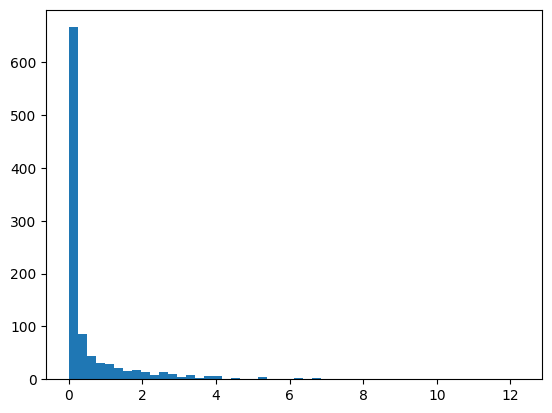

In [4]:
mean_events = 10000

def pseudoexperiment(seed = 0):

    background = 10000
    observed =  np.random.poisson(mean_events, 1)[0]

    ########## Likelihoods ##########
    def likelihood_function(b, s, N):
        return -2 * (stats.poisson.logpmf(N, b + s) )


    # Null hypothesis: s = 0 with PROFILED b. We need to minimize the likelihood to get the best fit b given the total_B and total_B_error
    def null_likelihood_function(bprime):
        return likelihood_function(bprime, 0, observed)



    minimization = minimize(null_likelihood_function, 100, bounds = [(0, None)])
    post_fit_B = minimization.x[0]

    null_likelihood = null_likelihood_function(background)
    likelihood = likelihood_function(observed, 0, observed)


    test_statistic =  (null_likelihood - likelihood)
    
    if observed < background:
        test_statistic = 0

    return test_statistic

    print("Seed: ", seed)
    print("Observed: ", observed)
    print("Best fit B: ", post_fit_B)


test_statistics = [pseudoexperiment(seed) for seed in range(1000)]
print(test_statistics)
plt.hist(test_statistics, bins = 50)

Median:  0.0
1sigma:  0.0 1.0382051002230737
2sigma:  0.0 1.9742643960541215
Percentile of 0:  0.0
Percentile of Z = 1:  0.829
Percentile of Z = 2:  0.975


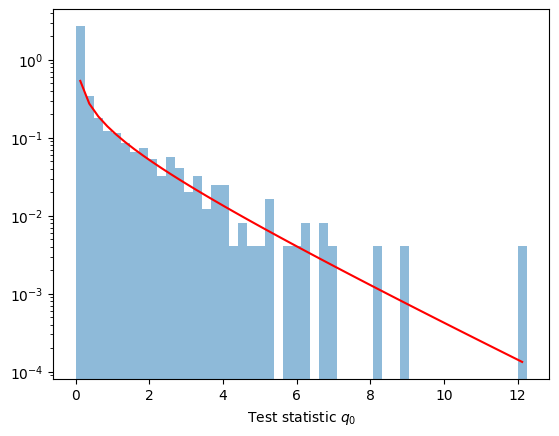

In [5]:
z_score = np.sqrt(test_statistics)
z_score = np.sort(z_score)
plt.hist(test_statistics, bins = 50, density = True, alpha = 0.5)

counts, bins = np.histogram(test_statistics, bins = 50, density = True)
centers = (bins[:-1] + bins[1:]) / 2

def f(q):
    return 1/(2*np.sqrt(q * 2 * np.pi)) * np.exp(-q/2)

plt.plot(centers, f(centers), label = "Asymptotic", color = "red")

plt.yscale("log")
plt.xlabel("Test statistic $q_0$")

# Print the median, 1sigma, and 2sigma values
print("Median: ", np.median(z_score))
print("1sigma: ", np.percentile(z_score, 16), np.percentile(z_score, 84))
print("2sigma: ", np.percentile(z_score, 2.5), np.percentile(z_score, 97.5))

# Print the percentile of z = 0, 1, 2
index = np.searchsorted(z_score, [0, 1, 2])
print("Percentile of 0: ", index[0] / len(z_score))
print("Percentile of Z = 1: ", index[1] / len(z_score))
print("Percentile of Z = 2: ", index[2] / len(z_score))

In [34]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1001
n_folds = 5

num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [35]:
# if train_samesign = False, this loads in the OS test data
# test 


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [36]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
upsilon_OS


-0.0023090770648431192 -0.0070321614917068734 -0.014370777989654289


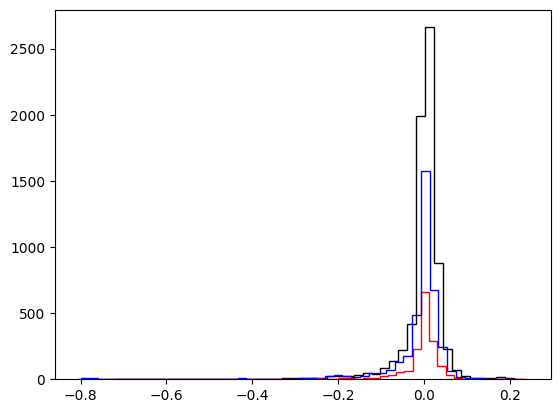

In [61]:
pseudo = 5

# Load in scores
data_dict_by_fold = all_test_data_splits[pseudo]
scores_dict_by_fold = all_scores_splits[pseudo]

all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
all_masses = scaler.inverse_transform(all_data[:,-1].reshape(-1,1))

in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
in_SBL = (all_masses < SR_left )
in_SBH = (all_masses > SR_right )

mass_SBL = all_masses[in_SBL]
mass_SR = all_masses[in_SR]
mass_SBH = all_masses[in_SBH]

scores_SBL = all_scores[in_SBL]
scores_SR = all_scores[in_SR]
scores_SBH = all_scores[in_SBH]

log_likelihoods_SBL = np.log(scores_SBL / (1 - scores_SBL))
log_likelihoods_SR = np.log(scores_SR / (1 - scores_SR))
log_likelihoods_SBH = np.log(scores_SBH / (1 - scores_SBH))

plt.hist(log_likelihoods_SBL, bins = 50, histtype = 'step', color = 'black', label = 'SBL')
plt.hist(log_likelihoods_SR, bins = 50, histtype = 'step', color = 'red', label = 'SR')
plt.hist(log_likelihoods_SBH, bins = 50, histtype = 'step', color = 'blue', label = 'SBH')

print(np.mean(log_likelihoods_SBL), np.mean(log_likelihoods_SR), np.mean(log_likelihoods_SBH))


# Get the likelihood assuming BCE
likelihood_ratios = (all_scores) / (1 - all_scores)
log_likelihoods = np.log(likelihood_ratios)
log_likelihood = np.sum(log_likelihoods)

# plt.hist(log_likelihood, bins = 50, histtype = 'step', color = 'black', label = 'Data')

In [79]:
def bdt_log_likelihood(pseudo):


    # Load in scores
    data_dict_by_fold = all_test_data_splits[pseudo]
    scores_dict_by_fold = all_scores_splits[pseudo]

    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = scaler.inverse_transform(all_data[:,-1].reshape(-1,1))

    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    scores_SBL = all_scores[in_SBL]
    scores_SR = all_scores[in_SR]
    scores_SBH = all_scores[in_SBH]

    # Get the likelihood assuming BCE
    likelihood_ratios = (scores_SR) / (1 - scores_SR)
    log_likelihoods = np.log(likelihood_ratios)
    log_likelihood = np.sum(log_likelihoods)

    return log_likelihood 



21.972036280830846 13.391827594237885
36.67874117712348


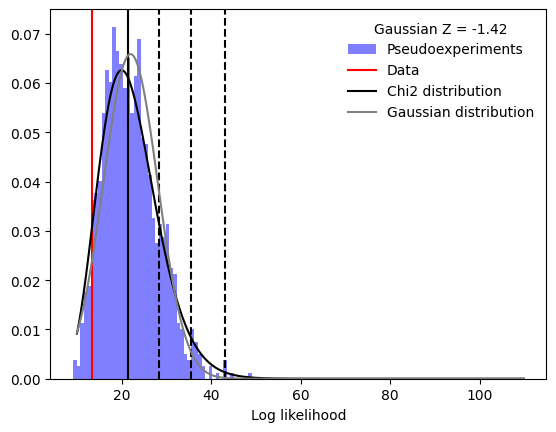

In [83]:
likelihoods = np.array([-2 * bdt_log_likelihood(pseudo) for pseudo in range(num_to_plot)])
pseudoexperiment_likelihoods = likelihoods[1:]
data_likelihood = likelihoods[0]

print(np.mean(pseudoexperiment_likelihoods), data_likelihood)
print(np.std(pseudoexperiment_likelihoods)**2 )

dof = 176

# plt.hist(pseudoexperiment_likelihoods[0], bins = 50, density = True, alpha = 0.5, color = "blue", label = "Pseudoexperiments")
# plt.hist(data_likelihood, bins = 50, density = True, alpha = 0.5, color = "red", label = "Data")

median = np.median(pseudoexperiment_likelihoods)
one_sigma = np.percentile(pseudoexperiment_likelihoods, 84)
two_sigma = np.percentile(pseudoexperiment_likelihoods, 97.5)
three_sigma = np.percentile(pseudoexperiment_likelihoods, 99.7)



plt.hist(pseudoexperiment_likelihoods, bins = 50, density = True, alpha = 0.5, color = "blue", label = "Pseudoexperiments")
plt.axvline(data_likelihood, color = "red", label = "Data")

plt.axvline(median, color = "black")
plt.axvline(one_sigma, color = "black", linestyle = "--")
plt.axvline(two_sigma, color = "black", linestyle = "--")
plt.axvline(three_sigma, color = "black", linestyle = "--")

# fit a lognormal distribution to the pseudoexperiments
mu = np.mean(pseudoexperiment_likelihoods)
sigma = np.std(pseudoexperiment_likelihoods)



mu = np.mean(pseudoexperiment_likelihoods)
sigma = np.std(pseudoexperiment_likelihoods)
x = np.linspace(10, mu * 5, 1000)
y = stats.chi2.pdf(x,  mu)
y_gauss = stats.norm.pdf(x, np.mean(pseudoexperiment_likelihoods), np.std(pseudoexperiment_likelihoods))

Z = (data_likelihood - np.mean(pseudoexperiment_likelihoods)) / np.std(pseudoexperiment_likelihoods)

plt.plot(x, y, color = "black", label = "Chi2 distribution")
plt.plot(x, y_gauss, color = "grey", label = "Gaussian distribution")

plt.xlabel("Log likelihood")
# plt.yscale("log")
legend_title = "Gaussian Z = {:.2f}".format(Z)
plt.legend(frameon = False, title = legend_title)


plt.show()


Optimization terminated successfully.
         Current function value: 506.651334
         Iterations: 1006
         Function evaluations: 1620
Optimization terminated successfully.
         Current function value: 494.833815
         Iterations: 959
         Function evaluations: 1544
Best fit: 504.105457539147
Null fit: 506.65133382110446
Test statistic: 2.545876281957476
Integrated signal: 97.16087836871407
Integrated background: 1594.839121631286


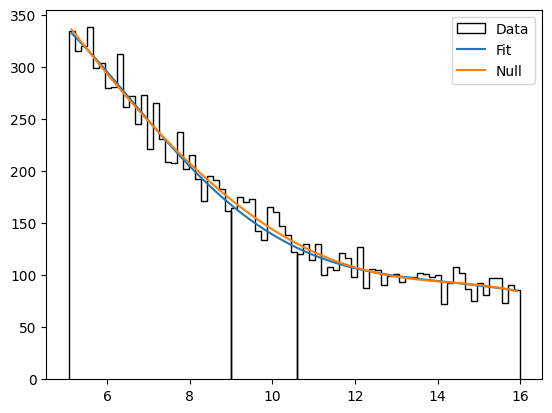

In [21]:
pseudo = 0


data_dict_by_fold = all_test_data_splits[pseudo]
scores_dict_by_fold = all_scores_splits[pseudo]


all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
all_masses = scaler.inverse_transform(all_data[:,-1].reshape(-1,1))



in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
in_SBL = (all_masses < SR_left )
in_SBH = (all_masses > SR_right )

mass_SBL = all_masses[in_SBL]
mass_SR = all_masses[in_SR]
mass_SBH = all_masses[in_SBH]

scores_SBL = all_scores[in_SBL]
scores_SR = all_scores[in_SR]
scores_SBH = all_scores[in_SBH]


filtered_masses = np.concatenate((mass_SBL, mass_SR, mass_SBH))

popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, "quintic", SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
s, b, q0 = calculate_test_statistic(filtered_masses, starting_guess = popt, verbose_plot = True)


mean:  0.4977147589558894


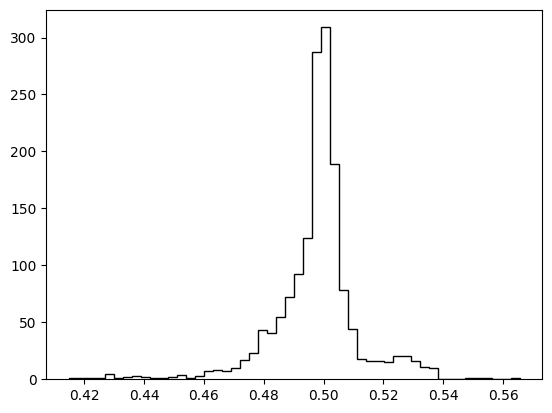

In [77]:
plt.hist(scores_SR, bins = 50, histtype = 'step', color = 'black', label = 'SR')
print("mean: ", np.mean(scores_SR))


28.9769689826081


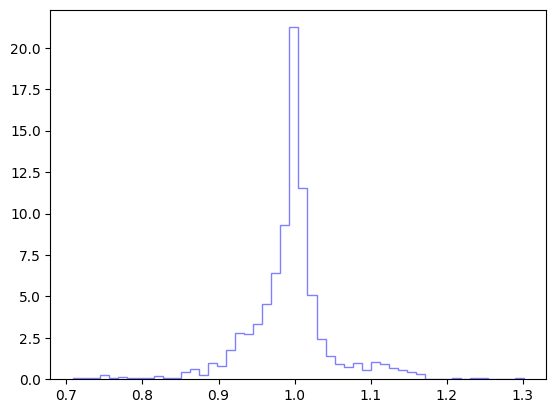

In [80]:
likelihood_ratios = (scores_SR) / (1 - scores_SR)
plt.hist(likelihood_ratios, bins = 50, histtype = 'step', color = 'blue', alpha = 0.5, label = 'q0', density = True)
log_likelihood_ratios = -2 * np.log(likelihood_ratios)
log_likelihood = np.sum(log_likelihood_ratios)
# print(log_likelihood_ratios)
print(log_likelihood_ratios.sum())
print(log_likelihood_ratios.mean())
# print("Number of events in SR: ", len(scores_SR))
# label = "-2 Likelihood ratio: " + str(log_likelihood)
# plt.hist(log_likelihood_ratios, bins = 50, histtype = 'step', color = 'blue', alpha = 0.5, label = 'q0', density = True)
# plt.legend(title = label)

In [31]:
n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -4, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff



n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -4, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff


        
def TEST_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):
            

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((1, num_experiments)), np.empty((1, num_experiments))
    significances = np.empty((1, num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # Get a list of all possible cuts for the feature
        feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

         # For each cut, calculate the number of signal and background events in the SR
        num_in_SBL = []
        num_in_SR = []
        num_in_SBH = []
        FPR = []
        for cut in feature_cut_points:
            num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
            num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
            num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


        fit_function = bkg_fit_quintic


        print(f"On pseudo experiment {pseudo_e+1}...")
        fpr_thresholds_test = [fpr_thresholds_finegrained[FPR_index],]
        for t, threshold in enumerate(fpr_thresholds_test ):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # get the fit function to SB background

            # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            
            S,B, q0 = calculate_test_statistic(filtered_masses, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "q0: ", q0)

        

            # q0 = S/np.sqrt(B + total_B_error**2)
            # if S < 0 or B < 0:
                # q0 = 0

            significances[t, pseudo_e] = np.sqrt(q0)

        
    
    return significances


In [32]:
# significancess = TEST_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)
# save_dir = f"plot_data/fpr_tests"
# with open(f"{save_dir}/significances_{FPR_index}", "wb") as ofile:
#     pickle.dump(significancess, ofile)


In [33]:
print(significancess.shape)

NameError: name 'significancess' is not defined

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

Text(0.5, 0.1, 'Asymptotic $f(q) = \\frac{1}{2}\\delta(q) + \\frac{1}{2}\\frac{1}{\\sqrt{2 \\pi q}}e^{-q/2}$')

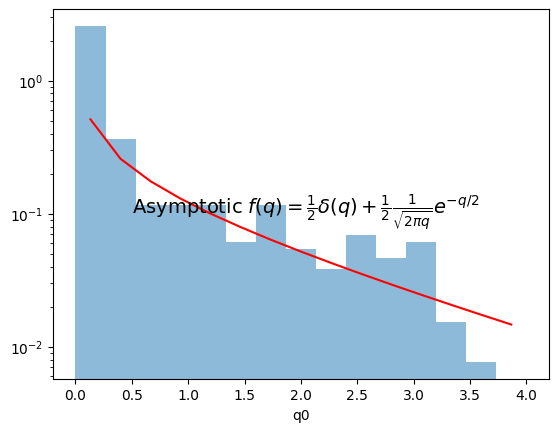

In [154]:
significances = significancess[0][1:]

key = "CATHODE"
z_score = significances
z_score = np.sort(z_score)
for i in range(len(z_score)):
    print(i, z_score[i])

# Print the median, 1sigma, and 2sigma values
print("Median: ", np.median(z_score))
print("1sigma: ", np.percentile(z_score, 16), np.percentile(z_score, 84))
print("2sigma: ", np.percentile(z_score, 2.5), np.percentile(z_score, 97.5))

# Print the percentile of z = 0, 1, 2
index = np.searchsorted(z_score, [0, 1, 2])
print("Percentile of 0: ", index[0] / len(z_score))
print("Percentile of Z = 1: ", index[1] / len(z_score))
print("Percentile of Z = 2: ", index[2] / len(z_score))

counts, bins = np.histogram(significances**2, bins = 15, density = True, range = (0, 4))
centers = (bins[:-1] + bins[1:]) / 2

plt.hist(significances**2, bins = 15, density = True, alpha = 0.5, range = (0, 4))

def f(q):
    return 1/(2*np.sqrt(q * 2 * np.pi)) * np.exp(-q/2)

plt.plot(centers, f(centers), color = "red")
plt.yscale("log")
plt.xlabel("q0")

text = r"Asymptotic $f(q) = \frac{1}{2}\delta(q) + \frac{1}{2}\frac{1}{\sqrt{2 \pi q}}e^{-q/2}$"
plt.text(0.5, 0.1, text, fontsize = 14)

[0.00000000e+00 1.14691895e+00 1.64376737e+00 7.85423787e-02
 0.00000000e+00 0.00000000e+00 3.04248862e-03 0.00000000e+00
 0.00000000e+00 8.79187892e-01 4.22897854e-01 2.04657929e+00
 3.75059408e-01 7.01940137e-01 0.00000000e+00 2.83968910e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.09992055e-01
 2.42912993e-01 0.00000000e+00 8.97361414e-01 1.28819852e+00
 3.72357029e-02 1.30479038e+00 0.00000000e+00 1.73623926e-01
 3.88592782e-01 0.00000000e+00 7.78238049e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.79030475e-01 0.00000000e+00
 0.00000000e+00 1.24731702e+00 6.99738484e-01 1.50881564e+00
 0.00000000e+00 7.61313986e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.78579522e-01 0.00000000e+00 4.11537998e-01
 0.00000000e+00 0.00000000e+00 1.57399317e+00 0.00000000e+00
 7.62641773e-02 9.25861621e-01 7.26286001e-01 0.00000000e+00
 4.86482833e-01 1.35670982e+00 8.85898200e-01 0.00000000e+00
 7.09672782e-01 1.52239858e+00 0.00000000e+00 0.00000000e+00
 3.07583818e-02 0.000000

Text(0.5, 0.1, 'Asymptotic $f(q) = \\frac{1}{2}\\delta(q) + \\frac{1}{2}\\frac{1}{\\sqrt{2 \\pi q}}e^{-q/2}$')

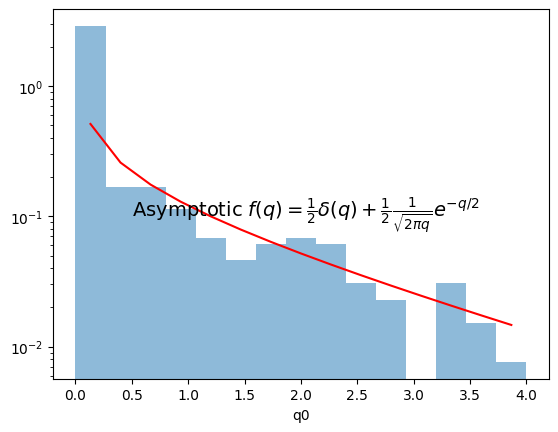

In [155]:
# significances = significancess[1][1:]

# key = "CATHODE"
# print(significances)
# z_score = significances
# z_score = np.sort(z_score)

# # Print the median, 1sigma, and 2sigma values
# print("Median: ", np.median(z_score))
# print("1sigma: ", np.percentile(z_score, 16), np.percentile(z_score, 84))
# print("2sigma: ", np.percentile(z_score, 2.5), np.percentile(z_score, 97.5))

# # Print the percentile of z = 0, 1, 2
# index = np.searchsorted(z_score, [0, 1, 2])
# print("Percentile of 0: ", index[0] / len(z_score))
# print("Percentile of Z = 1: ", index[1] / len(z_score))
# print("Percentile of Z = 2: ", index[2] / len(z_score))

# # Percage of signifcances that are 0
# print("Percentile of 0: ", np.sum(z_score == 0) / len(z_score))

# counts, bins = np.histogram(significances**2, bins = 15, density = True, range = (0, 4))
# centers = (bins[:-1] + bins[1:]) / 2

# plt.hist(significances**2, bins = 15, density = True, alpha = 0.5, range = (0, 4))

# def f(q):
#     return 1/(2*np.sqrt(q * 2 * np.pi)) * np.exp(-q/2)

# plt.plot(centers, f(centers), color = "red")
# plt.yscale("log")
# plt.xlabel("q0")

# text = r"Asymptotic $f(q) = \frac{1}{2}\delta(q) + \frac{1}{2}\frac{1}{\sqrt{2 \pi q}}e^{-q/2}$"
# plt.text(0.5, 0.1, text, fontsize = 14)

[0.9817251  0.14426672 0.         2.03839869 0.21232691 2.62505959
 0.         0.84877034 0.         0.         0.         1.32555857
 0.37073785 0.20408197 0.         1.1634299  0.         0.
 0.         0.         0.71907307 0.         1.42861924 0.07974074
 1.16948022 1.96673866 0.29234916 1.50994552 0.45236179 0.
 0.39872644 0.24500188 0.         0.         0.         0.
 0.         0.07875003 0.48077918 0.72889296 0.         0.
 0.12137884 0.         0.         0.57877104 0.99323838 0.43130738
 0.15009682 0.17316164 0.         0.72553692 0.0527912  0.
 0.10306753 0.         0.         1.10380814 0.         0.
 0.94953466 1.06508268 0.28310718 0.76751368 0.22302454 0.08173741
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.65465834
 1.29971333 0.5290189  0.19944337 0.28045071 0.04499986 0.
 0.50415941 0.         0.         0.16461134 1.31133651 0.3986646
 0.         0.76706307 0.         0.03178385 0.         0.58

Text(0.5, 0.1, 'Asymptotic $f(q) = \\frac{1}{2}\\delta(q) + \\frac{1}{2}\\frac{1}{\\sqrt{2 \\pi q}}e^{-q/2}$')

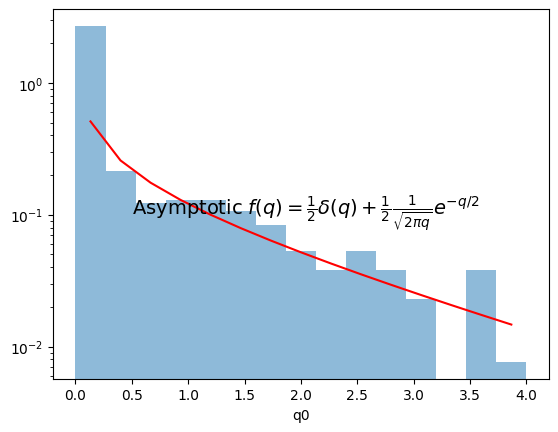

In [156]:
# significances = significancess[2][1:]

# key = "CATHODE"
# print(significances)
# z_score = significances
# z_score = np.sort(z_score)

# # Print the median, 1sigma, and 2sigma values
# print("Median: ", np.median(z_score))
# print("1sigma: ", np.percentile(z_score, 16), np.percentile(z_score, 84))
# print("2sigma: ", np.percentile(z_score, 2.5), np.percentile(z_score, 97.5))

# # Print the percentile of z = 0, 1, 2
# index = np.searchsorted(z_score, [0, 1, 2])
# print("Percentile of 0: ", index[0] / len(z_score))
# print("Percentile of Z = 1: ", index[1] / len(z_score))
# print("Percentile of Z = 2: ", index[2] / len(z_score))

# # Percage of signifcances that are 0
# print("Percentile of 0: ", np.sum(z_score == 0) / len(z_score))

# counts, bins = np.histogram(significances**2, bins = 15, density = True, range = (0, 4))
# centers = (bins[:-1] + bins[1:]) / 2

# plt.hist(significances**2, bins = 15, density = True, alpha = 0.5, range = (0, 4))

# def f(q):
#     return 1/(2*np.sqrt(q * 2 * np.pi)) * np.exp(-q/2)

# plt.plot(centers, f(centers), color = "red")
# plt.yscale("log")
# plt.xlabel("q0")

# text = r"Asymptotic $f(q) = \frac{1}{2}\delta(q) + \frac{1}{2}\frac{1}{\sqrt{2 \pi q}}e^{-q/2}$"
# plt.text(0.5, 0.1, text, fontsize = 14)

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1130037/1194190699.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(fprs, 0, one_sigma, alpha = 0.25, label = "1$\sigma$", color = "black")
/tmp/ipykernel_1130037/1194190699.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(fprs, 0, two_sigma, alpha = 0.25, label = "2$\sigma$", color = "black")


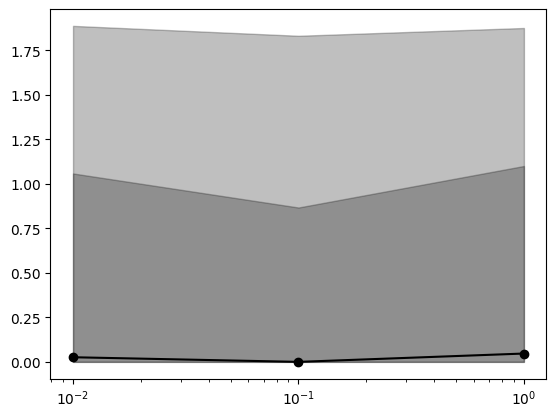

In [6]:
import matplotlib.pyplot as plt
import numpy as np

med = [.026042696390578803, 0.0, 0.04685278510245357]
one_sigma = [1.0583839738933054,  0.8671168065765918, 1.1003377022891243]
two_sigma = [1.8873922801335499, 1.8317919319818516, 1.8755455724561099]

fprs  = [0.01, 0.1, 1]
# plot
plt.plot(fprs, med, label = "Median", marker = "o", color = "black")

# fill band
plt.fill_between(fprs, 0, one_sigma, alpha = 0.25, label = "1$\sigma$", color = "black")
plt.fill_between(fprs, 0, two_sigma, alpha = 0.25, label = "2$\sigma$", color = "black")

plt.xscale("log")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[1.80540927 0.         0.         1.02389242 1.10917755 1.50811572
 0.         0.02029023 0.83297624 0.76705991 1.12031979 0.
 0.         0.         0.         0.         0.97098942 0.
 0.         0.         0.         0.99784177 0.4723737  0.
 0.         0.         0.69551128 0.         0.36578933 0.
 0.         0.         0.35669723 0.         0.46692722 0.90156117
 0.         0.         0.         0.         0.00295434 0.
 0.52718841 0.         0.         0.         0.         0.5470233
 0.         0.98669291 0.         0.         0.         0.73678165
 0.48538685 0.         1.01253789 0.         0.         0.45615093
 0.7087645  0.         0.         0.         0.         0.02270053
 0.         0.         0.         0.         1.57723888 0.
 0.         0.         0.         0.21019704 0.95472649 0.
 0.         0.         0.         0.         0.         1.18586812
 0.         0.         0.   

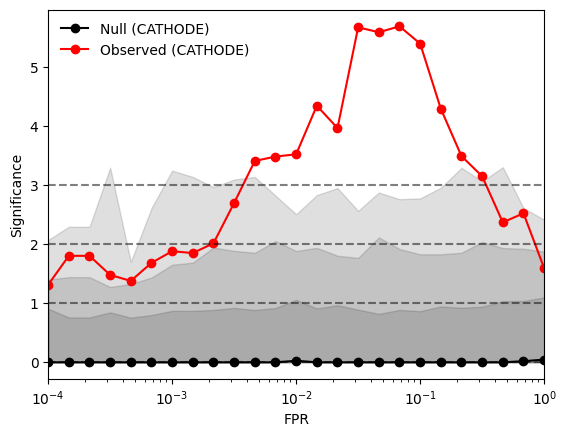

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

fpr_thresholds = np.logspace(0, -4, 25)
significances_all = []
index_list = []
for i in range(25):

    try:
        with open(f"plot_data/fpr_tests/significances_{i}", "rb") as ifile:
            # pickle.load(ifile)
            # print(f"Found {i}")
            significances = pickle.load(ifile)[0]
            index_list.append(i)
            significances_all.append(significances)
    except:
        print(f"Could not find {i}")


significances_all = np.nan_to_num(np.array(significances_all))
print(index_list)
significances_obs = significances_all[:,0]
significances_pseudo = significances_all[:,1:]

med = np.median(significances_pseudo, axis = 1)
one_sigma_upper = np.percentile(significances_pseudo, 16, axis = 1), np.percentile(significances_pseudo, 84, axis = 1)
one_sigma_lower = np.percentile(significances_pseudo, 84, axis = 1), np.percentile(significances_pseudo, 16, axis = 1)
two_sigma_upper = np.percentile(significances_pseudo, 2.5, axis = 1), np.percentile(significances_pseudo, 97.5, axis = 1)
two_sigma_lower = np.percentile(significances_pseudo, 97.5, axis = 1), np.percentile(significances_pseudo, 2.5, axis = 1)
three_sigma_upper = np.percentile(significances_pseudo, 0.15, axis = 1), np.percentile(significances_pseudo, 99.85, axis = 1)
three_sigma_lower = np.percentile(significances_pseudo, 99.85, axis = 1), np.percentile(significances_pseudo, 0.15, axis = 1)

print(significances_all[-2,:])

plt.plot(fpr_thresholds[index_list], med, label = "Null (CATHODE)", marker = "o", color = "black")
plt.fill_between(fpr_thresholds[index_list], one_sigma_lower[0], one_sigma_upper[0], alpha = 0.125, color = "black")
plt.fill_between(fpr_thresholds[index_list], two_sigma_lower[0], two_sigma_upper[0], alpha = 0.125, color = "black")
plt.fill_between(fpr_thresholds[index_list], three_sigma_lower[0], three_sigma_upper[0], alpha = 0.125, color = "black")

plt.plot(fpr_thresholds[index_list], significances_obs, label = "Observed (CATHODE)", marker = "o", color = "red")

plt.axhline(0, color = "black", linestyle = "--", alpha = 0.5)
plt.axhline(1, color = "black", linestyle = "--", alpha = 0.5)
plt.axhline(2, color = "black", linestyle = "--", alpha = 0.5)
plt.axhline(3, color = "black", linestyle = "--", alpha = 0.5)

plt.xlim(1e-4, 1)

plt.xscale("log")
plt.xlabel("FPR")
plt.ylabel("Significance")
plt.legend(frameon = False)

